Epoch 0 - Loss: 1.01526e+07
Epoch 10 - Loss: 1.75902e+07
Epoch 20 - Loss: 9.00076e+06
Epoch 30 - Loss: 6.93461e+06
Epoch 40 - Loss: 6.40078e+06
Epoch 50 - Loss: 6.31150e+06
Epoch 60 - Loss: 6.06429e+06
Epoch 70 - Loss: 5.83669e+06
Epoch 80 - Loss: 5.66277e+06
Epoch 90 - Loss: 5.55770e+06
Epoch 100 - Loss: 5.49662e+06
Epoch 110 - Loss: 5.46247e+06
Epoch 120 - Loss: 5.43948e+06
Epoch 130 - Loss: 5.42032e+06
Epoch 140 - Loss: 5.40376e+06
Epoch 150 - Loss: 5.38898e+06
Epoch 160 - Loss: 5.37506e+06
Epoch 170 - Loss: 5.36139e+06
Epoch 180 - Loss: 5.34756e+06
Epoch 190 - Loss: 5.33325e+06
Epoch 200 - Loss: 5.31814e+06
Epoch 210 - Loss: 5.30204e+06
Epoch 220 - Loss: 5.28482e+06
Epoch 230 - Loss: 5.26642e+06
Epoch 240 - Loss: 5.24672e+06
Epoch 250 - Loss: 5.22578e+06
Epoch 260 - Loss: 5.20380e+06
Epoch 270 - Loss: 5.18108e+06
Epoch 280 - Loss: 5.18447e+06
Epoch 290 - Loss: 5.13949e+06
Epoch 300 - Loss: 5.11467e+06
Epoch 310 - Loss: 5.24837e+06
Epoch 320 - Loss: 5.32995e+06
Epoch 330 - Loss: 5.1

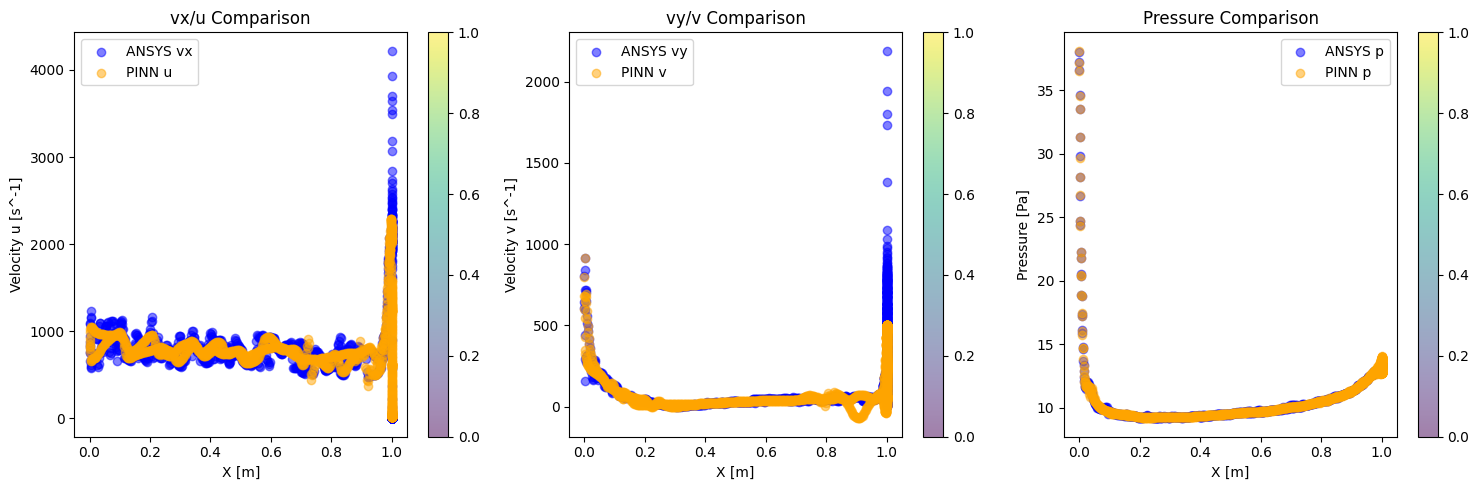

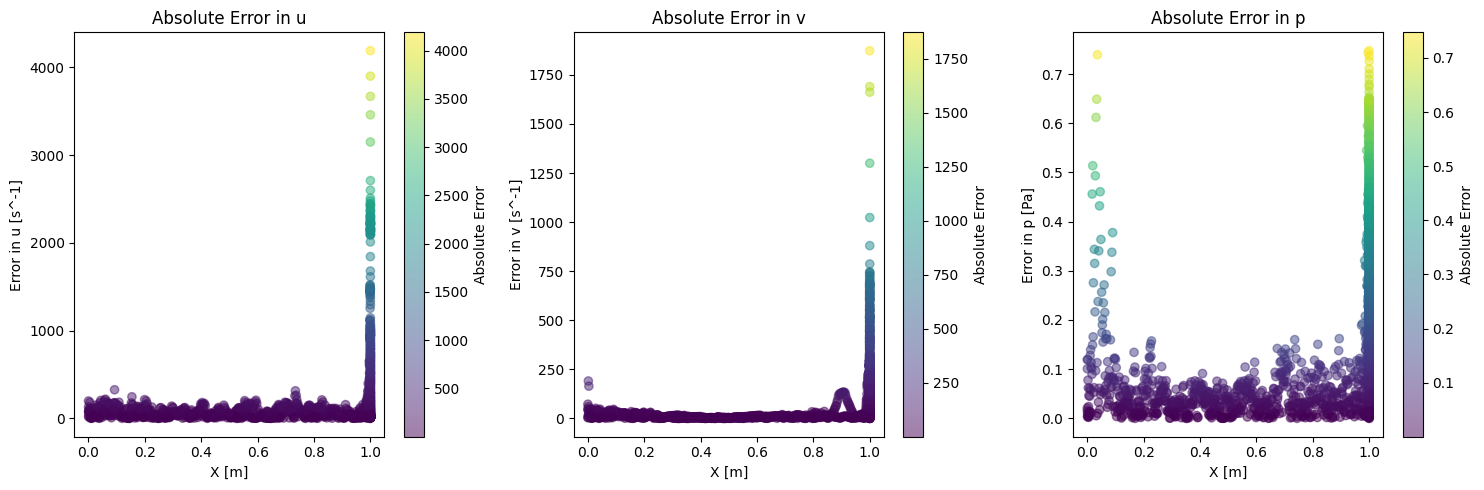

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define column names manually
column_names = ['X [m]', 'Y [m]', 'Pressure [Pa]', 'Velocity u.Gradient [s^-1]', 'Velocity v.Gradient [s^-1]']

# Load CSV file using pandas, skipping initial metadata rows and setting column names
data = pd.read_csv('/content/data913356.csv', skiprows=4, names=column_names, header=None)

# Convert columns to numeric, coercing errors to NaN
for column in column_names:
    data[column] = pd.to_numeric(data[column], errors='coerce')

# Remove rows with NaN values (if any, due to conversion errors)
data = data.dropna()

# Remove duplicate rows
data = data.drop_duplicates()

# Map columns to x, y, p, vx, vy
x = torch.tensor(data['X [m]'].values.reshape(-1, 1), dtype=torch.float32)
y = torch.tensor(data['Y [m]'].values.reshape(-1, 1), dtype=torch.float32)
p = torch.tensor(data['Pressure [Pa]'].values.reshape(-1, 1), dtype=torch.float32)
vx = torch.tensor(data['Velocity u.Gradient [s^-1]'].values.reshape(-1, 1), dtype=torch.float32)
vy = torch.tensor(data['Velocity v.Gradient [s^-1]'].values.reshape(-1, 1), dtype=torch.float32)

xy = torch.cat([x, y], dim=1)

# Compute normalization statistics
x_mean, x_std = x.mean(), x.std() if x.std() != 0 else 1.0
y_mean, y_std = y.mean(), y.std() if y.std() != 0 else 1.0
vx_mean, vx_std = vx.mean(), vx.std() if vx.std() != 0 else 1.0
vy_mean, vy_std = vy.mean(), vy.std() if vy.std() != 0 else 1.0
p_mean, p_std = p.mean(), p.std() if p.std() != 0 else 1.0

# Normalize inputs and targets
x_norm = (x - x_mean) / x_std
y_norm = (y - y_mean) / y_std
vx_norm = (vx - vx_mean) / vx_std
vy_norm = (vy - vy_mean) / vy_std
p_norm = (p - p_mean) / p_std
xy_norm = torch.cat([x_norm, y_norm], dim=1)

# PINN Model for each output
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=200):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # Single output
        )
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0, std=0.1)
                layer.bias.data.fill_(0)

    def forward(self, coords):
        return self.net(coords)

# Initialize separate models
model_u = PINN()
model_v = PINN()
model_p = PINN()

# Optimizers and schedulers
optimizer_u = torch.optim.Adam(model_u.parameters(), lr=1e-2)
optimizer_v = torch.optim.Adam(model_v.parameters(), lr=1e-2)
optimizer_p = torch.optim.Adam(model_p.parameters(), lr=1e-2)
scheduler_u = ReduceLROnPlateau(optimizer_u, mode='min', factor=0.5, patience=50)
scheduler_v = ReduceLROnPlateau(optimizer_v, mode='min', factor=0.5, patience=50)
scheduler_p = ReduceLROnPlateau(optimizer_p, mode='min', factor=0.5, patience=50)

# Boundary points
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
bc_x = torch.tensor([[x_min, y_min], [x_max, y_min], [x_min, y_max], [x_max, y_max]], dtype=torch.float32)
bc_x_norm = (bc_x - torch.tensor([[x_mean, y_mean]])) / torch.tensor([[x_std, y_std]])
bc_u = torch.zeros((4, 1))
bc_v = torch.zeros((4, 1))
bc_p = torch.mean(p) * torch.ones((4, 1))

def compute_residuals(model_u, model_v, model_p, xy_norm, x_std, y_std, vx_std, vy_std, p_std, viscosity=0.01):
    xy_norm.requires_grad_(True)
    u_norm = model_u(xy_norm)
    v_norm = model_v(xy_norm)
    p_norm = model_p(xy_norm)

    u = u_norm * vx_std + vx_mean
    v = v_norm * vy_std + vy_mean
    p = p_norm * p_std + p_mean

    grads_u = torch.autograd.grad(u.sum(), xy_norm, create_graph=True)[0]
    u_x = grads_u[:, 0:1] / x_std
    u_y = grads_u[:, 1:2] / y_std

    grads_v = torch.autograd.grad(v.sum(), xy_norm, create_graph=True)[0]
    v_x = grads_v[:, 0:1] / x_std
    v_y = grads_v[:, 1:2] / y_std

    grads_p = torch.autograd.grad(p.sum(), xy_norm, create_graph=True)[0]
    p_x = grads_p[:, 0:1] / x_std
    p_y = grads_p[:, 1:2] / y_std

    u_xx = torch.autograd.grad(u_x.sum(), xy_norm, create_graph=True)[0][:, 0:1] / x_std
    u_yy = torch.autograd.grad(u_y.sum(), xy_norm, create_graph=True)[0][:, 1:2] / y_std
    v_xx = torch.autograd.grad(v_x.sum(), xy_norm, create_graph=True)[0][:, 0:1] / x_std
    v_yy = torch.autograd.grad(v_y.sum(), xy_norm, create_graph=True)[0][:, 1:2] / y_std

    continuity = u_x + v_y
    momentum_u = u * u_x + v * u_y + p_x - viscosity * (u_xx + u_yy)
    momentum_v = u * v_x + v * v_y + p_y - viscosity * (v_xx + v_yy)

    continuity = continuity / (vx_std / x_std)
    momentum_u = momentum_u / (vx_std / x_std)
    momentum_v = momentum_v / (vy_std / y_std)

    return continuity, momentum_u, momentum_v

def total_loss(model_u, model_v, model_p, xy_norm, vx_norm, vy_norm, p_norm, xy_bc_norm, u_bc, v_bc, p_bc, x_std, y_std, vx_std, vy_std, p_std):
    # Data loss
    u_pred = model_u(xy_norm) * vx_std + vx_mean
    v_pred = model_v(xy_norm) * vy_std + vy_mean
    p_pred = model_p(xy_norm) * p_std + p_mean
    mse = nn.MSELoss()
    data_loss_u = mse(u_pred, vx)
    data_loss_v = mse(v_pred, vy)
    data_loss_p = mse(p_pred, p)
    data_loss = data_loss_u + data_loss_v + data_loss_p

    # Physics loss
    continuity, mom_u, mom_v = compute_residuals(model_u, model_v, model_p, xy_norm, x_std, y_std, vx_std, vy_std, p_std)
    physics_loss = (continuity**2).mean() + (mom_u**2).mean() + (mom_v**2).mean()

    # Boundary loss
    u_bc_pred = model_u(bc_x_norm) * vx_std + vx_mean
    v_bc_pred = model_v(bc_x_norm) * vy_std + vy_mean
    p_bc_pred = model_p(bc_x_norm) * p_std + p_mean
    bc_loss_u = mse(u_bc_pred, u_bc)
    bc_loss_v = mse(v_bc_pred, v_bc)
    bc_loss_p = mse(p_bc_pred, p_bc)
    bc_loss = bc_loss_u + bc_loss_v + bc_loss_p

    return 10.0 * data_loss + 0.001 * physics_loss + 10.0 * bc_loss

# Training loop
best_loss = float('inf')
for epoch in range(20000):
    model_u.train()
    model_v.train()
    model_p.train()

    optimizer_u.zero_grad()
    optimizer_v.zero_grad()
    optimizer_p.zero_grad()

    loss = total_loss(model_u, model_v, model_p, xy_norm, vx_norm, vy_norm, p_norm, bc_x_norm, bc_u, bc_v, bc_p, x_std, y_std, vx_std, vy_std, p_std)
    loss.backward()
    optimizer_u.step()
    optimizer_v.step()
    optimizer_p.step()

    scheduler_u.step(loss)
    scheduler_v.step(loss)
    scheduler_p.step(loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.5e}")
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save({'u': model_u.state_dict(), 'v': model_v.state_dict(), 'p': model_p.state_dict()}, 'best_models.pth')

# Load best models
checkpoint = torch.load('best_models.pth')
model_u.load_state_dict(checkpoint['u'])
model_v.load_state_dict(checkpoint['v'])
model_p.load_state_dict(checkpoint['p'])

# Predictions
model_u.eval()
model_v.eval()
model_p.eval()
with torch.no_grad():
    u_pred = model_u(xy_norm) * vx_std + vx_mean
    v_pred = model_v(xy_norm) * vy_std + vy_mean
    p_pred = model_p(xy_norm) * p_std + p_mean

# Compute absolute errors
u_error = torch.abs(u_pred - vx)
v_error = torch.abs(v_pred - vy)
p_error = torch.abs(p_pred - p)

# 2D Visualization - Original Comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sc = plt.scatter(x.numpy(), vx.numpy(), c='blue', label='ANSYS vx', alpha=0.5)
plt.scatter(x.numpy(), u_pred.numpy(), c='orange', label='PINN u', alpha=0.5)
plt.colorbar(sc)
plt.title("vx/u Comparison")
plt.xlabel("X [m]")
plt.ylabel("Velocity u [s^-1]")
plt.legend()

plt.subplot(1, 3, 2)
sc = plt.scatter(x.numpy(), vy.numpy(), c='blue', label='ANSYS vy', alpha=0.5)
plt.scatter(x.numpy(), v_pred.numpy(), c='orange', label='PINN v', alpha=0.5)
plt.colorbar(sc)
plt.title("vy/v Comparison")
plt.xlabel("X [m]")
plt.ylabel("Velocity v [s^-1]")
plt.legend()

plt.subplot(1, 3, 3)
sc = plt.scatter(x.numpy(), p.numpy(), c='blue', label='ANSYS p', alpha=0.5)
plt.scatter(x.numpy(), p_pred.numpy(), c='orange', label='PINN p', alpha=0.5)
plt.colorbar(sc)
plt.title("Pressure Comparison")
plt.xlabel("X [m]")
plt.ylabel("Pressure [Pa]")
plt.legend()

plt.tight_layout()
plt.savefig('pinn_comparison_2d_separate.png')

# 2D Visualization - Error Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sc = plt.scatter(x.numpy(), u_error.numpy(), c=u_error.numpy(), cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Absolute Error')
plt.title("Absolute Error in u")
plt.xlabel("X [m]")
plt.ylabel("Error in u [s^-1]")

plt.subplot(1, 3, 2)
sc = plt.scatter(x.numpy(), v_error.numpy(), c=v_error.numpy(), cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Absolute Error')
plt.title("Absolute Error in v")
plt.xlabel("X [m]")
plt.ylabel("Error in v [s^-1]")

plt.subplot(1, 3, 3)
sc = plt.scatter(x.numpy(), p_error.numpy(), c=p_error.numpy(), cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Absolute Error')
plt.title("Absolute Error in p")
plt.xlabel("X [m]")
plt.ylabel("Error in p [Pa]")

plt.tight_layout()
plt.savefig('pinn_error_2d_separate.png')